x (130, 3)
sigmapost [[ 1.00700823e-04 -3.21227164e-07 -1.45146618e-08]
 [-3.21227164e-07  1.00582569e-04  5.64084077e-09]
 [-1.45146618e-08  5.64084077e-09  1.00267950e-04]]
omega_samples (1000, 3)
[ 101544.6389781  -112442.92872293   -1329.77504893]
[ 101544.62842653 -112442.91609002   -1329.7897769 ]
[ 101544.633519   -112442.94157557   -1329.76161769]
[ 101544.62917647 -112442.93815186   -1329.78244702]
[ 101544.64077069 -112442.92419764   -1329.78255545]
[ 101544.63787561 -112442.9334607    -1329.77843309]
[ 101544.63998014 -112442.92412193   -1329.75708102]
[ 101544.62992898 -112442.93207397   -1329.76524769]
[ 101544.65705006 -112442.93766168   -1329.76981594]
[ 101544.62790176 -112442.94731412   -1329.77783975]
[ 101544.62473578 -112442.90975633   -1329.7560705 ]
[ 101544.63310468 -112442.9211657    -1329.78143222]
[ 101544.64210753 -112442.91453959   -1329.77471147]
[ 101544.63840041 -112442.91004396   -1329.76969914]
[ 101544.64631351 -112442.92537547   -1329.7772128 ]
[ 1015

/tmp/ipykernel_714/2173808544.py:10: RuntimeWarning: overflow encountered in exp
  p_y_i = 1.0 / (1.0 + np.exp(-np.dot(inputs[i], weights)))


[ 101544.64103615 -112442.91959803   -1329.78369159]
[ 101544.64363524 -112442.92671149   -1329.78127498]
[ 101544.6328149  -112442.93414638   -1329.75433761]
[ 101544.63268728 -112442.91609622   -1329.77607249]
[ 101544.62884782 -112442.91066475   -1329.77303052]
[ 101544.63828173 -112442.93640253   -1329.7790338 ]
[ 101544.64254403 -112442.91752308   -1329.76677479]
[ 101544.64596876 -112442.92498493   -1329.76282646]
[ 101544.64836578 -112442.90449945   -1329.74961058]
[ 101544.63204641 -112442.92060304   -1329.77361122]
[ 101544.63751597 -112442.92321446   -1329.77370994]
[ 101544.62924886 -112442.93260564   -1329.77658811]
[ 101544.63392571 -112442.95116898   -1329.79114378]
[ 101544.65313415 -112442.91344031   -1329.78150491]
[ 101544.63056285 -112442.92940719   -1329.76405402]
[ 101544.64214666 -112442.93088016   -1329.77231458]
[ 101544.63250129 -112442.92514613   -1329.7768002 ]
[ 101544.64539506 -112442.935365     -1329.75357177]
[ 101544.65483785 -112442.90636522   -1329.779

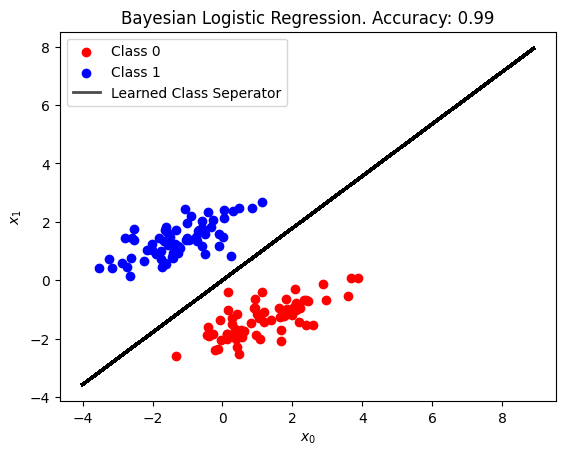

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import *


def predict_logistic(weights, inputs):
    p_y = []
    y_pred = []
    for i in range(inputs.shape[0]):
        p_y_i = 1.0 / (1.0 + np.exp(-np.dot(inputs[i], weights)))
        y_pred.append(np.round(p_y_i))
        p_y.append(p_y_i)
    return np.vstack(y_pred), np.vstack(p_y)


N = 130

label = np.zeros(shape=(N, 1))
mu1_true = 1.25 * np.array([1, -1])
Sigma_true = 1.5 * np.array([[0.9, 0.4], [0.4, 0.3]])
r1 = np.random.multivariate_normal(mean=mu1_true, cov=Sigma_true, size=N//2)
label[1:N//2] = 1
mu1_true = 1.25 * np.array([-1, 1])
Sigma_true = 1.5 * np.array([[.9, 0.4], [0.4, .3]])
r2 = np.random.multivariate_normal(mean=mu1_true, cov=Sigma_true, size=N//2)
label[N//2+1:N] = 0
data = np.concatenate((r1,r2), axis=0)
x = np.concatenate((data, np.ones(shape=(N,1))), axis=1)
print("x", x.shape)
sigma = np.zeros(shape=(N,1))

# priors
omega_prior = np.zeros(shape=(x.shape[-1],1))
Sigma_prior = 10000*np.eye(len(omega_prior))

omega_old = omega_prior
omega = 10*np.random.uniform(size=omega_prior.shape)
r = np.zeros(N)
sigma = np.zeros(N)
max_steps = 100
step = 0
while np.linalg.norm(omega - omega_old) > 0.1 and step <= max_steps:

    for i in range(N):
        clipped = np.clip(np.dot(x[i,:].T, omega), a_min=-20.0, a_max=20)
        sigma[i] = 1. / (1 + np.exp(-clipped))
        r[i] = sigma[i] * (1 - sigma[i])

    R = np.diag(r)

    omega_old = omega
    inner = np.dot(np.dot(x.T,R),x)
    sigma_label_dot = np.dot(x.T,(sigma - label))
    inv_sigma_prior = np.linalg.inv(Sigma_prior)
    dotres = np.sum(np.matmul(np.linalg.inv(inner+inv_sigma_prior+10*np.eye(3)), sigma_label_dot), axis=1, keepdims=True)
    omega = omega_old - dotres
    step = step + 1

omega_MAP = omega
Sigma_posterior = np.dot(np.dot(x.T,R),x)+np.linalg.inv(Sigma_prior)
print("sigmapost", Sigma_posterior)
omega_samples = np.random.multivariate_normal(omega_MAP[:, 0], Sigma_posterior, size=1000)
print("omega_samples", omega_samples.shape)
preds, _ = predict_logistic(weights=omega_MAP, inputs=x)
acc = accuracy_score(y_true=label, y_pred=preds)
f, ax = plt.subplots(1, 1)
ax.scatter(r1[:, 0], r1[:, 1], c='r', label="Class 0")
ax.scatter(r2[:, 0], r2[:, 1], c='b', label="Class 1")
ax.set_title("Bayesian Logistic Regression. Accuracy: %.2f" % acc)
xx = np.arange(-4, 9, 0.1)
for i in range(len(omega_samples)):
    omega = omega_samples[i]
    print(omega)
    a = -omega[2]/omega[1]-omega[0]/omega[1]
    yy = xx * a
    ax.plot(xx, yy, c='k', linewidth=2, alpha=0.7, label=None if i < len(omega_samples)-1 else "Learned Class Seperator")

ax.legend()
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
plt.show()